# 01. function

In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(SeuratObject))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(dplyr))
suppressMessages(library(ggrepel))
suppressMessages(library(gridExtra))
suppressMessages(library(ggsci))
suppressMessages(library(CellChat))
suppressMessages(library(NMF))
suppressMessages(library(ggalluvial))
suppressMessages(library(patchwork))
suppressMessages(library(svglite))
suppressMessages(library(Matrix))
suppressMessages(library(rjson))
suppressMessages(library(RColorBrewer))

In [2]:
ColorPalette <- function(number){
if (number <= 25){
    colorScheme = c('dodgerblue2', '#E31A1C', 'green4', '#6A3D9A', '#FF7F00', 'black', 'gold1',
                    'skyblue2', '#FB9A99', 'palegreen2', '#CAB2D6', '#FDBF6F', 'gray70', 'khaki2',
                    'maroon', 'orchid1', 'deeppink1', 'blue1', 'steelblue4', 'darkturquoise',
                    'green1', 'yellow4', 'yellow3','darkorange4', 'brown')
} else {
    suppressMessages(library(RColorBrewer))
    qual_col_pals <- brewer.pal.info[brewer.pal.info$category == 'qual',]
    colorScheme <- unique(unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals))))
    return (colorScheme)
    }
}



scRNA_2_rds=function(data){
    for(sampleid in unique(data$V1)) {
       print(sampleid)
           scRNAlist = {}
       for (i in (1:length(subset(data,data$V1==sampleid)$V3))){
           print(subset(data,data$V1==sampleid)$V3[i])
           counts <- Read10X(data.dir = subset(data,data$V1==sampleid)$V3[i],  gene.column = 1)
#           ribo.index = grep(pattern = "^RP[SL]", x = rownames(x = counts), value = FALSE)
#           mt.index = grep(pattern = "^MT-", x = rownames(x = counts), value = FALSE)
#           counts = counts[-ribo.index,]
#           counts =counts[-mt.index,]

           scRNAlist[[i]] <- CreateSeuratObject(counts,project=sampleid)
           scRNAlist[[i]] <- RenameCells(scRNAlist[[i]],add.cell.id = subset(data,data$V1==sampleid)$V2[i] )
       }
    }
    print(scRNAlist)
       if(length(scRNAlist)>1){
          scRNA=scRNAlist[[1]]
          for (j in (2:length(scRNAlist))){
          scRNA <- merge(scRNA,scRNAlist[j])
          }
       }else{
         scRNA=scRNAlist[[1]]
       }


#       cell <- strsplit(rownames(scRNA@meta.data),"_")
#       for(i in 1:dim(scRNA@meta.data)){scRNA@meta.data$lib[i] <- paste0(cell[[i]][1])}
       return (scRNA)
}


X10_2_rds=function(data){
    for(sampleid in unique(data$V1)) {
       print(sampleid)
           scRNAlist = {}
       for (i in (1:length(subset(data,data$V1==sampleid)$V3))){
           print(subset(data,data$V1==sampleid)$V3[i])
           counts <- Read10X(data.dir = subset(data,data$V1==sampleid)$V3[i],  gene.column = 2)
           ribo.index = grep(pattern = "^RP[SL]", x = rownames(x = counts), value = FALSE)
           mt.index = grep(pattern = "^MT-", x = rownames(x = counts), value = FALSE)
           counts = counts[-ribo.index,]
           counts =counts[-mt.index,]

           scRNAlist[[i]] <- CreateSeuratObject(counts,project=sampleid)
           scRNAlist[[i]] <- RenameCells(scRNAlist[[i]],add.cell.id = subset(data,data$V1==sampleid)$V2[i] )
      }
    }
    if(length(scRNAlist)>1){
          scRNA=scRNAlist[[1]]
          for (j in (2:length(scRNAlist))){
          scRNA <- merge(scRNA,scRNAlist[j])
          }
    }else{
         scRNA=scRNAlist[[1]]
    }
       return (scRNA)
}



multiplot <- function(..., plotlist = NULL, file, cols, layout = NULL) {
    library(grid)

    # Make a list from the ... arguments and plotlist
    plots <- c(list(...), plotlist)

    numPlots = length(plots)

    # If layout is NULL, then use 'cols' to determine layout
    if (is.null(layout)) {
        # Make the panel ncol: Number of columns of plots nrow: Number of rows
        # needed, calculated from # of cols
        layout <- matrix(seq(1, cols * ceiling(numPlots/cols)), ncol = cols,
            nrow = ceiling(numPlots/cols))
    }

    if (numPlots == 1) {
        print(plots[[1]])

    } else {
        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            # Get the i,j matrix positions of the regions that contain this subplot
            matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

            print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row, layout.pos.col = matchidx$col))
        }
    }
}


#########barplot
barplot <- function(data, outdir,prefixname){

    spot_gene=c()
    spot_mid=c()

    for(i in 2:dim(data)[2]){
            x=data[,i]
            p=which(x>0)
            spot_gene[i-1]=length(p)
            spot_mid[i-1]=sum(x)
    }
    sd1=sqrt(var(spot_gene))
    sd2=sqrt(var(spot_mid))
    stat1=summary(spot_gene)
    stat2=summary(spot_mid)


    pdf(paste0(outdir,prefixname,".unique_genes_or_transcripts_per_cell.pdf"),w=8,h=4)
    layout(matrix(1:2,1,2,byrow=TRUE),heights=c(1,1))
    h=hist(spot_gene,breaks=40,xlab="Number of unique genes per cell",ylab="Number of cells")
    my=max(h$counts)
    lines(x=c(mean(spot_gene),mean(spot_gene)),y=c(0,my),col="red",lty=2,lwd=2)
    text(x=mean(spot_gene),y=my,labels=round(mean(spot_gene)),col="red",pos=3,offset=-0.25)
    text(x=stat1[5]+stat1[5]/2,y=my,labels=paste("mean=",round(mean(spot_gene)),sep=""),col="red",pos=1,offset=-0.25,cex=0.8)
    text(x=stat1[5]+stat1[5]/2,y=my-my/10,labels=paste("median=",round(median(spot_gene)),sep=""),col="red",pos=1,offset=-0.25,cex=0.8)

    h2=hist(spot_mid,breaks=40,xlab="Number of unique transcripts per cell",ylab="Number of cells")
    my=max(h$counts)
    lines(x=c(mean(spot_mid),mean(spot_mid)),y=c(0,my),col="red",lty=2,lwd=2)
    text(x=mean(spot_mid),y=my,labels=round(mean(spot_mid)),col="red",pos=3,offset=-0.25)
    text(x=stat2[5]+stat2[5]/2,y=my,labels=paste("mean=",round(mean(spot_mid)),sep=""),col="red",pos=1,offset=-0.25,cex=0.8)
    text(x=stat2[5]+stat2[5]/2,y=my-my/10,labels=paste("median=",round(median(spot_mid)),sep=""),col="red",pos=1,offset=-0.25,cex=0.8)
    multiplot(h,h2,ncols=2)
    dev.off()
}




#（1）统计线粒体基因的丰度比

calc_percenterage_feature_set <- function(sce){
    #01 calculate percent of mt, ribo, hb and plat each bin
    sce <- PercentageFeatureSet(sce, '^MT-', col.name = "percent.mt")
    sce <- PercentageFeatureSet(sce, '^RP[SL]', col.name = "percent.ribo")
    sce <- PercentageFeatureSet(sce, '^HB[^(P)]', col.name = "percent.hb")
    return(sce)
}

filter_sce <- function(sce, minFeature, maxFeature, minCount, maxCount, minCell, mtRatio){
    # 官方教程仅对基因数以及线粒体基因的UMI比例做了限制，其它的参数后续可以自行添加
    selected_c <- WhichCells(sce, expression = (nCount_RNA > minCount & nCount_RNA < maxCount & nFeature_RNA > minFeature & nFeature_RNA < maxFeature & percent.mt < mtRatio))
                                                # & percent.ribo < rbRatio & percent.hb < hbRatio & percent.plat < platRatio))
    selected_f <- rownames(sce)[Matrix::rowSums(sce) > minCell]
    sce <- subset(sce, features = selected_f, cells = selected_c)
    return(sce)
}
# （4）聚类分析 SCTransform看起来是Normalizedata + Findvariablefeature + Scaledata三个流程整合在一起的集成算法
Normalization <- function(sce, outdir,prefixname,Normalization, dims = 50){
    if (Normalization){
       sce <- NormalizeData(sce, normalization.method = "LogNormalize", scale.factor = 10000)
    }

    sce <- FindVariableFeatures(sce, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(sce)
    sce <- ScaleData(sce, features = all.genes)
    sce <- RunPCA(sce)
    sce <- FindNeighbors(sce, dims = 1:dims)
    return(sce)
}

Clustering <- function(sce, outdir,prefixname,dims = 50, resolution){
    sce <- FindClusters(sce, verbose = FALSE, resolution = resolution)
    sce <- RunUMAP(sce, dims = 1:dims,verbose = F,check_duplicates = FALSE)
    sce <- RunTSNE(sce, dims = 1:dims,verbose = F,check_duplicates = FALSE)
    return(sce)
}


search_marker<-function(sce,output_dir,prefixname,resolution){

    markers <- FindAllMarkers(sce, only.pos =FALSE, min.pct = 0.1)
    write.table(markers,file=paste(output_dir,prefixname,".All_makers_",resolution,".xls",sep=""),sep="\t",quote=F,row.names=F)
    top_markers=markers %>% group_by(cluster) %>% top_n(n = 100, wt = avg_log2FC)
    write.table(top_markers,file=paste(output_dir,prefixname,".Top_makers_",resolution,".xls",sep=""),sep="\t",quote=F,row.names=F)
    return (markers)
#    markers.auc <- wilcoxauc(st_dat)# 计算AUC
#    write.table(markers.auc,file=paste(output_dir,prefixname,".All_makers_",resolution,"auc.xls",sep=""),sep="\t",quote=F,row.names=F)
}

# GO analysis
go_enrichment <- function(rds,markers,prefix,organism,output_dir){
    library(clusterProfiler)
    library(org.Hs.eg.db)
    library(org.Mm.eg.db)
    library(enrichplot)
    library(ggnewscale)
    if (organism == "Human"){
        ref_db <- "org.Hs.eg.db"
    } else if (organism == "Mouse"){
        ref_db <- "org.Mm.eg.db"
    }
    markers=subset(markers,markers[,5]<0.01)
    markers=subset(markers,markers[,2]>0.1)
    gen=list()
    for(i in as.numeric(levels(rds))){
     dat=subset(markers,markers[,6]==i & markers[,5]<0.01)
     gene=dat[[7]] ## rowname有问题,请勿用
     pos=grep("Rp[sl]",gene,ignore.case=TRUE)
     if(length(pos)>0){
      gene=gene[-pos]
     }
     ids=bitr(gene,fromType='SYMBOL',toType='ENTREZID',OrgDb=ref_db)
     gen=c(gen,list(ids[[2]]))
    }
    names(gen)=paste("C",levels(rds),sep="")
    x<-compareCluster(gen,fun='enrichGO',OrgDb=ref_db,ont="BP")
     p1 <- dotplot(x)
     ggsave(p1,filename=paste(output_dir,"/",prefix,".exlude_Rps_L_All_cluster","_GO_enrichment_dotplot.pdf",sep=""),height = 10, width = 12)
    for(i in as.numeric(levels(rds))){
        dat=subset(markers,markers[,6]==i & markers[,5]<0.01)
        gene=dat[[7]]
        gene=data.frame(gene)
        names(gene)="SYMBOL"
        #ids=bitr(gene,fromType="SYMBOL",toType=c("UNIPROT","ENSEMBL"),OrgDb="org.Hs.eg.db")
        go2 <- enrichGO(gene= gene$SYMBOL,OrgDb= org.Hs.eg.db,keyType= 'SYMBOL',ont= "BP",pAdjustMethod = "BH",pvalueCutoff = 0.01,qvalueCutoff = 0.05)
        write.table(go2,file=paste(output_dir,"/",prefix,".cluster_",i,"_exlude_Rps_L.xls",sep=""),row.names=F,col.names=T,quote=F)
        p1=barplot(go2,showCategory=40)
        p1
        ggsave(p1,file=paste(output_dir,"/",prefix,".cluster_",i,"_exlude_Rps_L_GO_BP_enrichment.pdf",sep=""),w=8,h=8)
#        dev.off()
        p1=goplot(go2)
        p1
        ggsave(p1,file=paste(output_dir,"/",prefix,".cluster_",i,"_exlude_Rps_L_GO_network.pdf",sep=""),w=8,h=8)
        p1=heatplot(go2,showCategory = 40)
        p1
        ggsave(p1,file=paste(output_dir,"/",prefix,".cluster_",i,"_exlude_Rps_L_GO_enrichment_heatmap.pdf",sep=""),w=16,h=8)
        p1=dotplot(go2,showCategory = 40)
        p1
        ggsave(p1,file=paste(output_dir,"/",prefix,".cluster_",i,"_exlude_Rps_L_GO_enrichment_dotplot.pdf",sep=""),w=16,h=8)
    }
}
Volcano_plot <- function(df){
    partnumber=unique(df$cluster,fromLast = TRUE)
    clustermax=length(partnumber)
    clustermax
    df$label <- ifelse(df$p_val_adj<0.05,"Adjusted P-val<0.05","Adjusted P-val>=0.05")
    top10sig <-  df %>% group_by(cluster) %>% slice_max(n = 10, order_by = avg_log2FC)
    df$size <- case_when(!(df$gene %in% top10sig$gene)~ 1,df$gene %in% top10sig$gene ~ 2)
    dt <- filter(df,size==1)

    p <- ggplot()+geom_jitter(data = dt,aes(x = cluster, y = avg_log2FC, color = label),size = 0.85,width =0.4)+geom_jitter(data = top10sig,aes(x = cluster, y = avg_log2FC, color = label),size = 1,width =0.4)

    avg_log2FC_max=vector()
    avg_log2FC_min=vector()
    j=0;
    for(i in partnumber){
             dd <- filter(df,cluster==i)
             avg_log2FC_max[j+1]=max(dd$avg_log2FC)
             avg_log2FC_min[j+1]=min(dd$avg_log2FC)
        j=j+1
    }
    cat(avg_log2FC_min,"\n")
    dfbar<-data.frame(x=partnumber,y=avg_log2FC_max)
    dfbar1<-data.frame(x=partnumber,y=avg_log2FC_min)
    p2 <- ggplot()+geom_col(data = dfbar,mapping = aes(x = x,y = y),fill = "#dcdcdc",alpha = 0.8)+geom_col(data = dfbar1,mapping = aes(x = x,y = y),fill = "#dcdcdc",alpha = 0.6)+geom_jitter(data = dt,aes(x = cluster, y = avg_log2FC, color = label),size = 0.85,width =0.4)+geom_jitter(data = top10sig,aes(x = cluster, y = avg_log2FC, color = label),size = 1,width =0.4)
    dfcol<-data.frame(x=partnumber,y=0,label=partnumber)
    allcol <- c("#FF0000FF","#FF9900FF","#FFCC00FF","#00FF00FF","#6699FFFF","#CC33FFFF","#99991EFF","#999999FF","#FF00CCFF","#CC0000FF","#FFCCCCFF","#FFFF00FF","#CCFF00FF","#358000FF","#0000CCFF","#99CCFFFF","#00FFFFFF","#CCFFFFFF","#9900CCFF","#CC99FFFF","#996600FF","#666600FF","#666666FF","#CCCCCCFF","#79CC3DFF","#CCCC99FF")
    allcol <- c("#3182BDFF","#E6550DFF","#31A354FF","#756BB1FF","#636363FF","#6BAED6FF","#FD8D3CFF","#74C476FF","#9E9AC8FF","#969696FF","#9ECAE1FF","#FDAE6BFF","#A1D99BFF","#BCBDDCFF","#BDBDBDFF","#C6DBEFFF","#FDD0A2FF","#C7E9C0FF","#DADAEBFF","#D9D9D9FF")

    mycol <-allcol[1:clustermax]
    p3 <- p2 + geom_tile(data = dfcol,aes(x=x,y=y),height=0.6,color = "black",fill = mycol,alpha =0.95,show.legend = F)
    p4 <- p3 + geom_text_repel(data=top10sig,aes(x=cluster,y=avg_log2FC,label=gene),force = 1.2,arrow = arrow(length = unit(0.008, "npc"),type = "open", ends = "last"))
    p5 <- p4 + scale_color_manual(name=NULL,values = c("red2","black"))
    p6 <- p5 + labs(x="Cluster",y="average logFC")+ geom_text(data=dfcol, aes(x=x,y=y,label=label), size =5,color ="white")
    p7 <- p6+ theme_minimal()+ theme(axis.title = element_text(size = 18,color = "black",face = "bold"),axis.line.y = element_line(color = "black",size = 1.2),axis.text.y =element_text(size=15) ,axis.line.x = element_blank(),axis.text.x = element_blank(),panel.grid = element_blank(),legend.position = "top",legend.direction = "vertical",legend.justification = c(1,0),legend.text = element_text(size = 15))
    p7
    return(p7)
}

In [4]:
plot.clusters.group = function (data = seurat_data,clusters = seurat_clusters,
                                    group = orig.ident,widths = c(3,1),log =TRUE,
                                    legend.title = "Group",color = 1,xlab = ""){
 ## take an integrated Seurat object, plot distributions over orig.ident
 library(Seurat)
 library(patchwork)
 library(ggplot2)
 library(reshape2)
 library(RColorBrewer)
# library(paletteer)
 mytheme = theme(plot.title = element_text(size = 20,color="black",hjust = 0.5),
                 axis.title = element_text(size = 16,color ="black"),
                 axis.text = element_text(size=14,color = "black"),
                 #axis.line = element_line(color = "black"),
                 #axis.ticks = element_line(color = "black"),
                 panel.grid.minor.y = element_blank(),
                 panel.grid.minor.x = element_blank(),
                  panel.grid=element_blank(), # 去网格线
                 # legend.position = "none",
                 legend.text = element_text(size=14),
                 legend.title= element_text(size= 14),
                 # axis.text.x = element_text(angle = 45, hjust=1, vjust=1)
)
 
 count_table <- table(data@meta.data[,clusters], data@meta.data[,group])
 count_mtx <- as.data.frame.matrix(count_table)
 count_mtx$cluster <- rownames(count_mtx)
 melt_mtx <- melt(count_mtx)
 
 cluster_size <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)
 
 colnames(melt_mtx)[2] <- "dataset"
mycol= c("#3182BDFF","#E6550DFF","#31A354FF","#756BB1FF","#636363FF","#6BAED6FF","#FD8D3CFF","#74C476FF","#9E9AC8FF","#969696FF","#9ECAE1FF","#FDAE6BFF","#A1D99BFF","#BCBDDCFF","#BDBDBDFF","#C6DBEFFF","#FDD0A2FF","#C7E9C0FF","#DADAEBFF","#D9D9D9FF")
allcol <- c("#3182BDFF","#E6550DFF","#31A354FF","#756BB1FF","#636363FF","#6BAED6FF","#FD8D3CFF","#74C476FF","#9E9AC8FF","#969696FF","#9ECAE1FF","#FDAE6BFF","#A1D99BFF","#BCBDDCFF","#BDBDBDFF","#C6DBEFFF","#FDD0A2FF","#C7E9C0FF","#DADAEBFF","#D9D9D9FF")
    
################### p1  
 if(log){
   p1 <- ggplot(cluster_size, aes(y= cluster,x = value)) + geom_bar(position="dodge", stat="identity",fill = "grey60") +
     theme_bw() + scale_x_log10() + xlab("Cells per cluster, log10 scale") + ylab("") + mytheme
}else{
   p1 <- ggplot(cluster_size, aes(y= cluster,x = value)) + geom_bar(position="dodge", stat="identity",fill = "grey60") +
     theme_bw() + xlab("Cells per cluster") + ylab("") + mytheme
}
################### p2    
 ########################### color 1  
 if(color==1){
 if(length(unique(melt_mtx$dataset)) < 21){
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity",) + theme_bw() + coord_flip() +
     scale_fill_manual(values = alpha(mycol, 0.9))+
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="top") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}else{
   warning("The color limit is <21")
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
   geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
   ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
   theme(legend.position="top") + guides(fill = guide_legend(title = legend.title)) +
   scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}
}
 ########################### color 2
 if(color==2){
 if(length(unique(melt_mtx$dataset)) < 9){
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity",) + theme_bw() + coord_flip() +
     scale_fill_brewer(palette = "Set2")+
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="top") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}else{
   warning("The color limit is <9")
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="top") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}
}
 wrap_plots(ncol = 2,p2,p1,widths = widths)
}

plot.clusters.sample = function (data = seurat_data,clusters = seurat_clusters,
                                    group = orig.ident,widths = c(3,1),log =TRUE,
                                    legend.title = "Group",color = 1,xlab = ""){
 ## take an integrated Seurat object, plot distributions over orig.ident
 library(Seurat)
 library(patchwork)
 library(ggplot2)
 library(reshape2)
 library(RColorBrewer)
# library(paletteer)
 mytheme = theme(plot.title = element_text(size = 20,color="black",hjust = 0.5),
                 axis.title = element_text(size = 16,color ="black"),
                 axis.text = element_text(size=14,color = "black"),
                 #axis.line = element_line(color = "black"),
                 #axis.ticks = element_line(color = "black"),
                 panel.grid.minor.y = element_blank(),
                 panel.grid.minor.x = element_blank(),
                  panel.grid=element_blank(), # 去网格线
                 # legend.position = "none",
                 legend.text = element_text(size=14),
                 legend.title= element_text(size= 14),
                 # axis.text.x = element_text(angle = 45, hjust=1, vjust=1)
)
 
 count_table <- table(data@meta.data[,clusters], data@meta.data[,group])
 count_mtx <- as.data.frame.matrix(count_table)
 count_mtx$cluster <- rownames(count_mtx)
 melt_mtx <- melt(count_mtx)
# melt_mtx$cluster <- as.factor(melt_mtx$cluster)
 
 cluster_size <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)
 
# if("0" %in% cluster_size$cluster){
#   sorted_labels <- paste(sort(as.integer(levels(cluster_size$cluster)),decreasing = T))
#}else{
#   sorted_labels <- paste(cluster_size$cluster[order(cluster_size$value)])
#}
 
# cluster_size$cluster <- factor(cluster_size$cluster,levels = sorted_labels)
# melt_mtx$cluster <- factor(melt_mtx$cluster,levels = sorted_labels)
 
 colnames(melt_mtx)[2] <- "dataset"
 
 ########################### color 1  
 if(color==1){
 if(length(unique(melt_mtx$dataset)) < 21){
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity",) + theme_bw() + coord_flip() +
     scale_fill_manual(values = alpha(mycol, 0.9))+
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="right") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}else{
   warning("The color limit is <21")
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
   geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
   ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
   theme(legend.position="right") + guides(fill = guide_legend(title = legend.title)) +
   scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}
}
 ########################### color 2
 if(color==2){
 if(length(unique(melt_mtx$dataset)) < 9){
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity",) + theme_bw() + coord_flip() +
     scale_fill_brewer(palette = "Set2")+
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="right") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}else{
   warning("The color limit is <9")
   p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
     geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
     ylab(paste0("Fraction of cells in each ",tolower(legend.title))) + xlab(xlab) +
     theme(legend.position="right") + guides(fill = guide_legend(title = legend.title)) +
     scale_y_continuous(labels = scales::percent,expand = c(0.01, 0.01))+ mytheme
}
}
 wrap_plots(ncol = 2,p2,widths = widths)
}

# 02. standard analysis

In [4]:
setwd("./")

In [6]:
indir<-".//ovary/matrix/10X/"
output_dir="./"
prefix="33y40y49y253y"

In [6]:
library(harmony)
minFeature=100
maxFeature=4000
minCount=200
maxCount=20000
minCell=5
mtRatio=30


Loading required package: Rcpp



In [7]:
age33y <-read.table(paste0(indir,"33y.txt"),header=F)
age33y <-X10_2_rds(age33y)
age40y <-read.table(paste0(indir,"40y.txt"),header=F)
age40y <-X10_2_rds(age40y)
age49y2 <-read.table(paste0(indir,"49y2.txt"),header=F)
age49y2 <-X10_2_rds(age49y2)
age53y <-read.table(paste0(indir,"53y.txt"),header=F)
age53y <-X10_2_rds(age53y)

In [ ]:
scRNA=age33y
scRNA <- merge(scRNA,age40y)
scRNA <- merge(scRNA,age49y2)
scRNA <- merge(scRNA,age53y)

In [ ]:
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize", scale.factor = 10000)
scRNA <- PercentageFeatureSet(scRNA, '^MT-', col.name = "percent.mt")
scRNA <- PercentageFeatureSet(scRNA, '^RP[SL]', col.name = "percent.ribo")
scRNA <- PercentageFeatureSet(scRNA, '^HB[^(P)]', col.name = "percent.hb")
scRNA <- subset(scRNA, subset = nFeature_RNA > minFeature & nFeature_RNA < maxFeature & percent.mt <= mtRatio)
scRNA <- ScaleData(scRNA,vars.to.regress =c("percent.mt","nCount_RNA"))
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000)
scRNA <- RunPCA(scRNA,features = VariableFeatures(object =scRNA),npcs=50, verbose=FALSE)
scRNA <- RunHarmony(scRNA, group.by.vars="orig.ident", assay.use="RNA", max.iter.harmony = 20)
scRNA <- RunUMAP(scRNA, reduction = "harmony", dims = 1:50)
scRNA <- RunTSNE(scRNA, reduction = "harmony", dims = 1:50)
scRNA <- FindNeighbors(scRNA, reduction="harmony", dims = 1:50)

In [ ]:
saveRDS(scRNA, file =  paste0(output_dir,"/",prefix,".",".UMAP.rds"))

# 03. Remove doublets

In [ ]:
library(dplyr)
library(DoubletFinder)
sweep.res.list <- paramSweep_v3(scRNA,PCs=1:20,sct=T)
sweep.stats <- summarizeSweep(sweep.res.list,GT=FALSE)
bcmvn <- find.pK(sweep.stats)
pK_bcmvn <- bcmvn$pK[which.max(bcmvn$BCmetric)]%>% as.character()%>% as.numeric()
DoubletRate=ncol(scRNA)*8*1e-6
homotypic.prop <- modelHomotypic(scRNA$seurat_clusters)
nExp_poi <- round(DoubletRate*ncol(scRNA))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))
scRNA <- doubletFinder_v3(scRNA,PCs=1:50,pN=0.25,pK=pK_bcmvn,nExp=nExp_poi.adj,reuse.pANN=F,sct=T)
scRNA@meta.data$DF<- scRNA@meta.data$DF.classifications_0.25_0.22_7601
scRNA <- subset(scRNA, subset = DF=="Singlet")
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize", scale.factor = 10000)
scRNA <- ScaleData(scRNA,vars.to.regress =c("percent.mt","nCount_RNA"))
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000)
scRNA <- RunPCA(scRNA,features = VariableFeatures(object =scRNA),npcs=50, verbose=FALSE)
scRNA <- RunHarmony(scRNA, group.by.vars="orig.ident", assay.use="RNA", max.iter.harmony = 20)
scRNA <- RunUMAP(scRNA, reduction = "harmony", dims = 1:50)
scRNA <- RunTSNE(scRNA, reduction = "harmony", dims = 1:50)
scRNA <- FindNeighbors(scRNA, reduction="harmony", dims = 1:50)
saveRDS(scRNA, file =  paste0(output_dir,"/",prefix,".","final.rds")

# 04. Cell type identification

In [7]:
scRNA <- readRDS(paste0(output_dir,"/",prefix,".","final.rds"))

In [ ]:
resolutions <- c(0.2,0.3,0.4,0.5,0.6)
for(resolution in resolutions){
   scRNA <- FindClusters(scRNA, resolution =resolution )
}

In [ ]:
scRNA.markers <- FindAllMarkers(scRNA, only.pos = FALSE, min.pct = 0.1, logfc.threshold = 0.1)
write.csv(scRNA.markers, file =paste0(output_dir,"/",prefix,".",0.2,".markers.xls"))

In [ ]:
Idents(object = scRNA) <- scRNA@meta.data$RNA_snn_res.0.2
scRNA <- RenameIdents(object = scRNA, '0'= "T&C_0",'1'="T&C_1",'2'="SMC_1",'3'= "endo",'4'="immune",'5'="SMC_2",'6'="endo(CCL21+)")

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


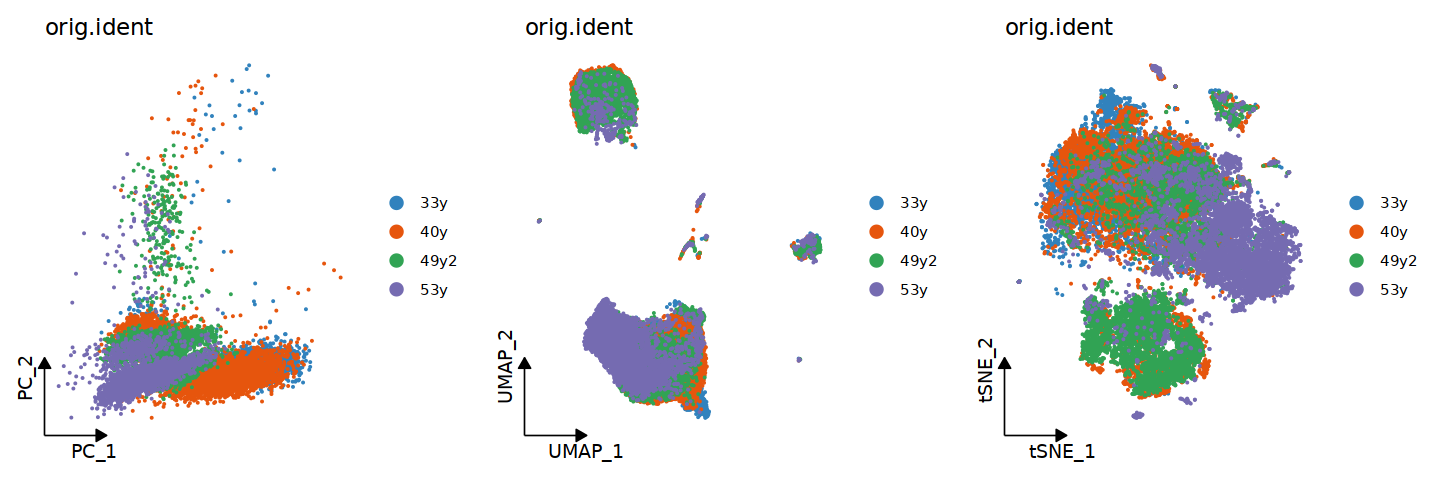

In [22]:
allcol <- c('#EC8532',"#3BBCA8",'#999999','#E787BD','#D2352B','#9C5A33','#4A7DB4',"#208A42","#89288F","#8A9FD1","#89C75F", "#6E4B9E","#0C727C", "#7E1416","#D8A767","#3D3D3D")
allcol <- c("#FF0000FF","#FF9900FF","#FFCC00FF","#6699FFFF","#CC33FFFF","#99991EFF","#999999FF","#FFCCCCFF","#FFFF00FF","#CCFF00FF","#358000FF","#0000CCFF","#99CCFFFF","#00FFFFFF","#CCFFFFFF","#9900CCFF","#CC99FFFF","#996600FF","#666600FF","#666666FF","#CCCCCCFF","#79CC3DFF","#CCCC99FF")
allcol <- c("#3182BDFF","#E6550DFF","#31A354FF","#756BB1FF","#636363FF","#6BAED6FF","#FD8D3CFF","#74C476FF","#9E9AC8FF","#969696FF","#9ECAE1FF","#FDAE6BFF","#A1D99BFF","#BCBDDCFF","#BDBDBDFF","#C6DBEFFF","#FDD0A2FF","#C7E9C0FF","#DADAEBFF","#D9D9D9FF")
mytheme.dim=theme(panel.grid=element_blank(), plot.title = element_text(size = 20,color="black",hjust = 0.5),axis.text.x = element_text(size = 15, color = 'black'),axis.text.y = element_text(size = 15, color = 'black'),axis.title.x = element_text(size = 15, color = 'black'),axis.title.y = element_text(size = 15, color = 'black'),axis.ticks = element_line(color = 'black', lineend = 'round'),legend.position = 'right',legend.text = element_text(size = 15, color = 'black'),legend.title = element_text(size = 15, color = 'black'),panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))+dr
options(repr.plot.width =12,repr.plot.height =4)
mytheme = theme(
                 legend.text = element_text(size=16),
                 legend.title= element_text(size= 18) )
pca <- DimPlot(scRNA, reduction = "pca",group.by="orig.ident",cols=allcol)+mytheme.dim#+scale_fill_manual(values = alpha(paletteer::paletteer_d('ggsci::category20c_d3'), 0.65)) +scale_color_manual(values = alpha(paletteer::paletteer_d('ggsci::category20c_d3'), 0.65))+dr
umap <- DimPlot(scRNA, reduction = "umap",group.by="orig.ident",cols=allcol)+mytheme.dim#+dark_theme_bw()+dark_theme_void()+mytheme
tsne <- DimPlot(scRNA, reduction = "tsne",group.by="orig.ident",cols=allcol)+mytheme.dim
tsne <- DimPlot(scRNA, reduction = "tsne",group.by="orig.ident",cols=allcol)+mytheme.dim
p=CombinePlots(
  plots = list(pca,umap,tsne),
  nrow =1
)
ggsave(paste0("33y40y49y253y","pca+umap+tsne.sample.pdf"),plot=p,w=12,h=4)
p

In [40]:
table(scRNA@meta.data$celltype)


       T&C_0        T&C_1        SMC_1         endo       immune        SMC_2 
       11225         8070         5382          396          331           64 
endo(CCL21+) 
          29 

In [ ]:
table(scRNA@meta.data$celltype,scRNA@meta.data$orig.ident)

              
                33y  40y 49y2  53y
  T&C_0         794 1981 2475 5975
  T&C_1        3637 3233  817  383
  SMC_1          43 1063 4075  201
  endo           28   73  226   69
  immune         19   75   98  139
  SMC_2           0    0    0   64
  endo(CCL21+)    6    2   10   11

In [161]:
table(scRNA@meta.data$orig.ident)


 33y  40y 49y2  53y 
4527 6427 7701 6842 

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


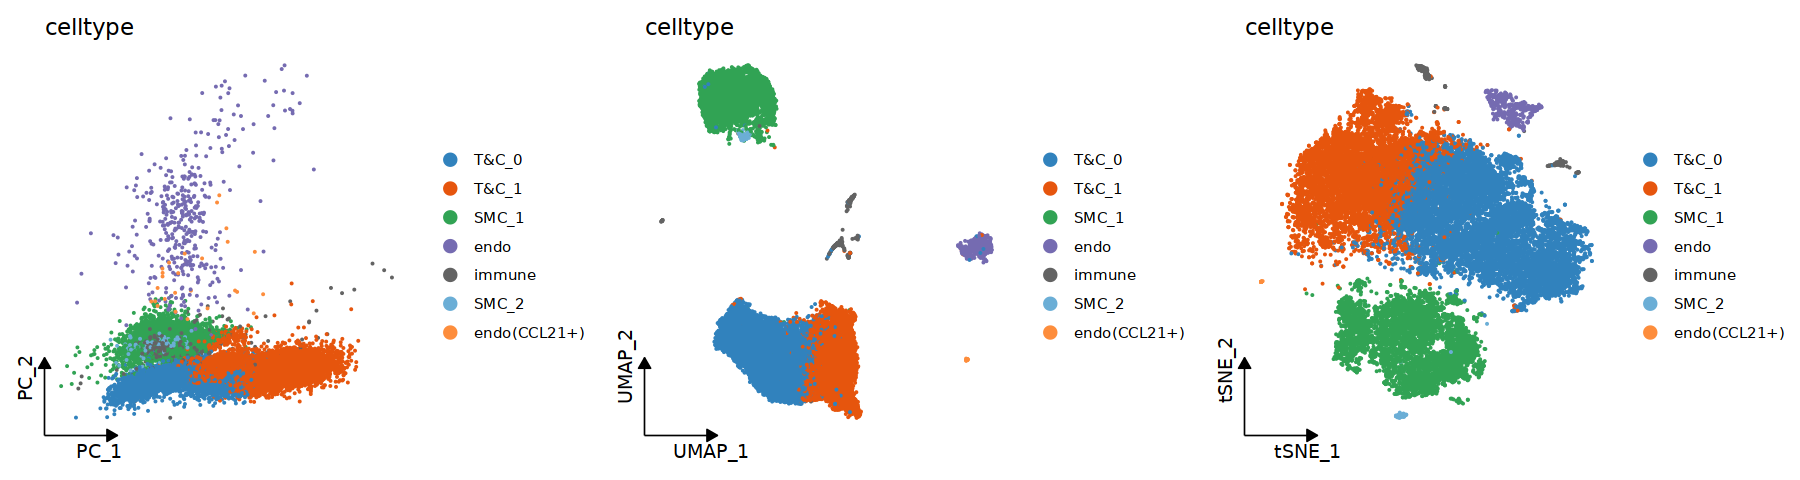

In [42]:
Idents(object = scRNA) <- scRNA@meta.data$RNA_snn_res.0.2
scRNA <- RenameIdents(object = scRNA, '0'= "T&C_0",'1'="T&C_1",'2'="SMC_1",'3'= "endo",'4'="immune",'5'="SMC_2",'6'="endo(CCL21+)")
allcol <- c('#EC8532',"#3BBCA8",'#999999','#E787BD','#D2352B','#9C5A33','#4A7DB4',"#208A42","#89288F","#8A9FD1","#89C75F", "#6E4B9E","#0C727C", "#7E1416","#D8A767","#3D3D3D")
allcol <- c("#FF0000FF","#FF9900FF","#FFCC00FF","#6699FFFF","#CC33FFFF","#99991EFF","#999999FF","#FFCCCCFF","#FFFF00FF","#CCFF00FF","#358000FF","#0000CCFF","#99CCFFFF","#00FFFFFF","#CCFFFFFF","#9900CCFF","#CC99FFFF","#996600FF","#666600FF","#666666FF","#CCCCCCFF","#79CC3DFF","#CCCC99FF")
allcol <- c("#3182BDFF","#E6550DFF","#31A354FF","#756BB1FF","#636363FF","#6BAED6FF","#FD8D3CFF","#74C476FF","#9E9AC8FF","#969696FF","#9ECAE1FF","#FDAE6BFF","#A1D99BFF","#BCBDDCFF","#BDBDBDFF","#C6DBEFFF","#FDD0A2FF","#C7E9C0FF","#DADAEBFF","#D9D9D9FF")
mytheme.dim=theme(panel.grid=element_blank(), plot.title = element_text(size = 20,color="black",hjust = 0.5),axis.text.x = element_text(size = 15, color = 'black'),axis.text.y = element_text(size = 15, color = 'black'),axis.title.x = element_text(size = 15, color = 'black'),axis.title.y = element_text(size = 15, color = 'black'),axis.ticks = element_line(color = 'black', lineend = 'round'),legend.position = 'right',legend.text = element_text(size = 15, color = 'black'),legend.title = element_text(size = 15, color = 'black'),panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"))+dr
options(repr.plot.width =15,repr.plot.height =4)
mytheme = theme(
                 legend.text = element_text(size=16),
                 legend.title= element_text(size= 18) )
pca <- DimPlot(scRNA, reduction = "pca",group.by="celltype",cols=allcol)+mytheme.dim#+scale_fill_manual(values = alpha(paletteer::paletteer_d('ggsci::category20c_d3'), 0.65)) +scale_color_manual(values = alpha(paletteer::paletteer_d('ggsci::category20c_d3'), 0.65))+dr
umap <- DimPlot(scRNA, reduction = "umap",group.by="celltype",cols=allcol)+mytheme.dim#+dark_theme_bw()+dark_theme_void()+mytheme
tsne <- DimPlot(scRNA, reduction = "tsne",group.by="celltype",cols=allcol)+mytheme.dim
tsne <- DimPlot(scRNA, reduction = "tsne",group.by="celltype",cols=allcol)+mytheme.dim
p=CombinePlots(
  plots = list(pca,umap,tsne),
  nrow =1
)
ggsave(paste0("33y40y49y253y","pca+umap+tsne.celltype.pdf"),plot=p,w=15,h=4)
p

Using cluster as id variables



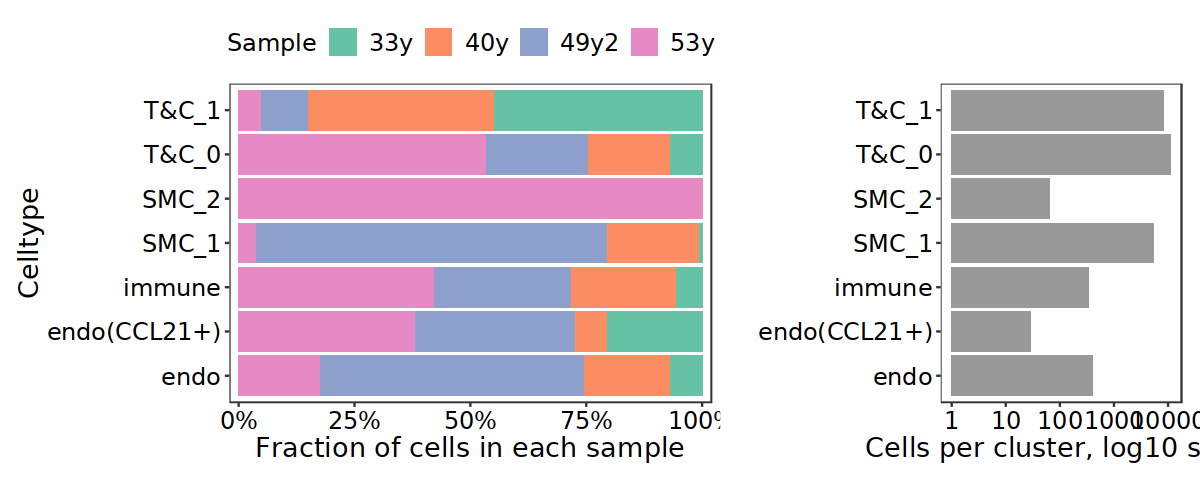

In [32]:
scRNA@meta.data$celltype <- Idents(object = scRNA)
scRNA@meta.data$celltype <- factor(scRNA@meta.data$celltype,levels=c("T&C_0","T&C_1","SMC_1","SMC_2","endo","endo(CCL21+)","immune"))
options(repr.plot.width =10,repr.plot.height =5)
p1 = plot.clusters.group(data = scRNA,clusters =  "celltype", 
                         xlab = "Celltype", log = TRUE,
                         group = "orig.ident",legend.title = "Sample",
                         widths = c(4,2),color = 2)
options(repr.plot.width =10,repr.plot.height =4)
p1
ggsave(paste0("33y40y49y253y",".group_celltype_percent.pdf"),plot=p1,width =10,height =4)




 33y  40y 49y2  53y 
4527 6427 7701 6842 

Using cluster as id variables



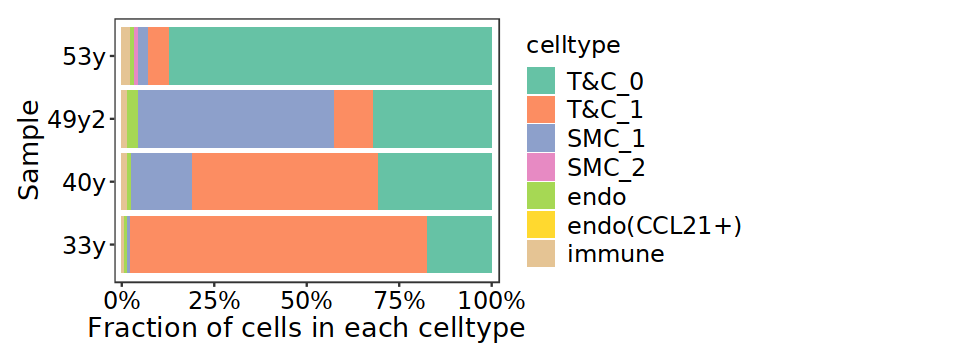

In [33]:
scRNA@meta.data$samples <- factor(scRNA@meta.data$orig.ident,levels=c("33y","40y","49y2","53y"))
table(scRNA@meta.data$samples)
options(repr.plot.width =8,repr.plot.height =3)
p1 = plot.clusters.sample(data = scRNA,clusters =  "samples", 
                         xlab = "Sample", log = TRUE,
                         group = "celltype",legend.title = "celltype",
                         widths = c(4,2),color = 2)

options(repr.plot.width =8,repr.plot.height =3)
p1
ggsave(paste0("33y40y49y253y",".group_sample_percent.pdf"),plot=p1,width =8,height =3)



In [39]:
allgene=rownames(scRNA@assays$RNA)
PMID19189975.agerelated_gene.down<- c("TFRC","COL3A1","COL1A1","COL4A5","FABP3","ATP5G3","NDUFB11","CX3CL1","CA4","CALB1","GHITM","UQCRQ","C5orf13","ACSS2","UQCRFS1","DIABLO")
PMID19189975.agerelated_gene.down <- intersect(PMID19189975.agerelated_gene.down,allgene)
PMID19189975.agerelated_gene.up<-c("APOD","FCGR2B","C3","CLU","CTSS","LYZ","IGJ","C1QA","S100A6","GFAP","MT1F","C1QB","LGALS3","MGST1","ANXA3","ANXA5","S100A4","GPNMB","GSTA1","C1QC","VWF","DERL1","NDRG1","Rat:Ania4","FCGR2A","GBP2","GNS","IL33","MPEG1","NPC2","ADIPOR2","B2M","LITAF","SERPING1","HCST","RNF213","C4A","SPP1","CLIC4","EFEMP1","LAPTM5","VAT1","HIST1H1C","KIAA0494","PTGES3","Rat:LOC360231","RASA3","PSMD11","SGK1","TXNIP","Mouse:Igh-VJ558","HBA1","HLA-G","PCSK6","TMED10")
PMID19189975.agerelated_gene.up <- intersect(PMID19189975.agerelated_gene.up,allgene)

# 05.gene module score

In [13]:
m1 =c("FOS","JUNB","EGR1","ZFP36","NR4A1","FOSB","C11orf96","SERPINE1","MT2A","EMP1","GADD45B","ADAMTS4","SOCS3","CDKN1A","ATF3","MT1X","LDLR","GPRC5A","MAFF","KLF4","MIDN","VMP1","LINC00513","BHLHE40","NFATC2","NAMPT","SAMD4A","RFX2","KLF6")
m2=c("ADAMTS1","MTND1P23","NR4A2","ZNF331","ZBTB16","MT-TV","MEG3","PER1","ATP1B3","MTCO3P13","NR4A3","NEAT1","FKBP5","KLF9","PDE10A","MTCO3P31","CRISPLD2","F3","ESYT2","TIPARP","GRK5","MT1E","ELL2","LENG8","PTPRG","PLA2G5","LONRF2","TACC1","CCNH","PGAP1","CASP9","PLXNA2","USP36","PVT1","SIK2","SLC2A3","FOXK2","NFATC1","EVA1C","TSC22D2","BCL6")
m3=c("C3","CD74","HLA-A","CXCL10","GBP1","CXCL9","CTSD","HLA-DRA","IRF1","GPNMB","HLA-DRB1","TAP1","HLA-DPA1","APOL1","HLA-DRB5","S100A8","DEFA3","SRGN","NNMT","TM4SF1","S100A9","LIPA","SAMHD1","TPSB2","ALOX15B","OSMR","HLA-DQB2","GZMM","IFNG-AS1","DTHD1","HAS2")
m4=c("COL1A1","COL3A1","ACTA2","TAGLN","ISG15","CCN2","CCN1","CCL21","A2M","ELN","IGF1","VWF","CLDN5","PLAC9","ADAMTS9","NOTCH3","LIMS2","PLXND1","PALM2AKAP2","PECAM1")
m5=c("DLK1","MYH11","TIMP3","MEG8","DES","MCAM","ADH1B","ADAMTS16","GSE1","SLIT3","PRKG1","EPAS1","TMOD1","EBF1","TINAGL1","SOD3","CACNA1C","CHSY1","MAMDC2","SERTAD1","CD9","PITPNC1","ANGPTL1","MTRNR2L1","TENT5A","RCAN2","ZFHX3","CARMIL1","ATP11A","TMTC1","CFLAR","SNORD114-3","LONRF3","ADAMTSL4-AS2")
m6=c("AEBP1","GPX3","KAZN","RUNX1","IL1R1","GPM6A","EFNA5","SPSB1","PDZRN4","SORBS2","AFF3","CMIP","SYT1","MAML2","MSRB3","NEBL","SLC12A2","TNXB","PTGR1","EIF5B","GAS7","HIPK2","MINDY2","RAPGEF3","ENOX1","ST3GAL1","KIAA1671")
m7=c("CACNB2","LINC-PINT","PTPRD","LARGE1","PRKN","BACH2","NAALADL2","ARHGAP10","GALNT17","ROR2","MED13L","ZHX2","BTBD9","DIAPH2","SLC24A3","SMURF1","TYW1")
m8=c("IGHG4","IGKC","IGHG1","IGHG3","IGHGP","JCHAIN","IGLC2","IGLC3","IGLL5","IGHA1","IGHG2","IGKV3-11","IGLV2-8","IGHA2","IGLV1-44","IGLV1-40","IGKV2-28","IGLV2-14","IGLV2-11","IGHV3-30","IGHM","IGLV6-57","IGLV3-16","IGLC7","IGKV1D-43","IGLV2-23","IGLV3-25","IGLVI-70","IGKV1D-13","IGLV1-47","IGLV8-61","IGLV3-19","IGKJ5","IGLV3-10","IGKV4-1","IKBKB-DT","SIGLEC14","CLECL1","LINC02273","CD44-AS1")
m9=c("APBB2","CMSS1","FCHSD2","BIRC6","ATXN2","RBM6","CBLB","CFAP298-TCP10L","LRBA","NFAT5","MAPK10","GPHN","LRCH3","CBFA2T2","KIF13A")
m10=c("INSL3","MT-ND3","APOE","GSTA1","MT-ND1","DHCR24","APOC1","KCNIP4","GRAMD1B","KCNMA1","FAM155A","NPC1","MAGI1","ADAM12","NAV2","CSH1","ADAMTS14","PRLHR","ADAMTS8","CSH2","SMIM24","KCNIP4-IT1","DPF1","SATB1-AS1","TMEM63C","LINC01346","IQGAP3","KLK4","LINC01335","TNNI1","PPARGC1B","B3GNT3","LGI3","PWRN4","THY1-AS1","LINC00968","AOC2","KLK13","CCDC9B","DNAH17-AS1","GALNT12","GJB2","PRR33","PPIAP66","MRPL20-DT","CHRNA2")
m11=c("MRTFA","MYO15B","LIFR","SIK3","MTHFR","SLC7A14-AS1","SKI","ARIH1","ZSWIM6","PPARD","SETBP1","AGO2","HDAC4","BRAF","GREB1L","SFMBT2")
m12=c("SLC26A3","RASGEF1B","LINGO1","MICOS10","APOO","RPL13P12","MT-TP","BCOR","PATJ","SORCS2","MT-RNR1","LUM","UPK3B","CRIP1","MTCO3P44","MTCO3P43","MTCO1P23","CD24","RAPGEF4","WNT2","HOXD10","IGLV2-34","PGC","MTRNR2L5","RPL30P14","PGAM1P5","PCK1","RPL23AP78","NPHS2","ANXA8","RPS27AP6","PGA5","RNU1-27P","ILDR2","PGBP","RPL15P21","HMGB1P50","RPS6P3","LRP2","RGPD3","ATP4B","MTND5P12","RPS27AP3","COX5BP1")
m13=c("FHIT","WWOX","NPAS3","DLGAP1","SNX29","KIAA1217","MACROD2","ANKS1B","SUPT3H","KALRN","DSCAML1","AGAP1","CACNA2D1","RLF")
m14=c("BMPR2","AKAP13","RNF145","LRRFIP1","RNF149","ADAM17","SLC25A37","DEPTOR","CMAHP","CLIP1","RFX3","PRKCE","SRGAP1","XYLT1","RPS6KA3","ETV6","TRIM5","SUGCT","ANKRD13C","BTAF1","MAPKBP1","VWA8","RAPGEF2","EVI5","BAZ1A","TIAM2","UBE4B","THADA","TRAPPC9","ADK","INO80","CPEB3","TAF3","CDK17","USP32","HDAC8","MOB1B","TAF1","ABL2","VTI1A","DIS3L2","CLASRP","FBXO42","ARMH3")
m15=c("RPL34","RPS7","TMSB10","FTL","ADIRF","RBMS3-AS3","LRRC75A","ZFPM2-AS1","BBOF1","CITED4","TSTD3")
m16=c("PDCD5","FBLN1","LOXL2","CNTNAP2","CSMD1","RBFOX1","CDH13","THSD4","GPC5","PRKAG2","KANK1","SKA3","SETD9","DCAF4L1","GABRA3","SLC25A3P1","KRT32","H3Y1","LINC02635","LINC00299","SLC24A2","KIAA1549L","NPY1R","LINC02889","FAM9B","CHGA","TPTE","MYH15","SGPP2","ELOVL2-AS1","C9orf135","OVOL1","LINC02725","CFAP61","NAIPP1","PLEKHD1","IGF2BP1","CBLN2","GPR150","ZNF695","ADAMTS7P3","NEB","PCDH20","SLC22A20P","LINC02484","OR2G6","CRYBB3","CCDC187","FOXA1","NCMAP","ISL1","KLRC2","PRSS55","WDFY3-AS1","LINC01681","SERPINI2","LINC00692","IQANK1","SCG3","SLC1A6","LINC01405","MYH16","SOX1-OT","NBPF21P","TSPYL6","SPATA4","LINC02405","LINC00488","LINC02271","CCDC175","IL17REL","ZNF716","LINC02586","HRG","FOXA2","FTH1P1","ADAMTSL4-AS1","EVPL","C4orf17","ATP6V1G2-DDX39B","SLC26A9","PCSK1","C12orf77","TBX5","BNIP5","DEPDC1-AS1","EBLN1","NLGN1-AS1","MTCO3P45","SLC6A13","FAM21EP","SNORD99")
m17=c("KDM4B","PRKAR2A","FAM13B","CELF1","DENND2A","SRPK2","MICAL3","TULP4","TRERF1","C20orf194","UBR2","REV3L","MAPK8IP3","FBXL20","GATAD2B","METTL16","SUZ12P1","ZFYVE9")
m18=c("HSPA1B","DNAJB1","HSPA1A","RN7SK","KIF5C-AS1","ZNF277","CAND2","HBA2","HBB","HBA1","DIPK1A","HBD","CRLF1","HBG1","RN7SL664P","GLA","MIR205HG","KRT5","RNU6-17P","KLF1","SLC4A1","FXYD3","RNU2-36P")
m19=c("IDI1","NXN","SREBF2","ARL15","LDB2","TBC1D1","AXL","HIP1","SIPA1L1","ABCC1","LIMA1","DOCK6","PACS1","DENND5A","ARFGAP3","FUT8","PIP5K1A","GATAD2A","RAB11FIP3")
m20=c("SLCO5A1","HFM1","ADAMTSL1","EPHA6","SGCZ","LTBP1","DMD","RYR2","DCLK1","SDK1","NCKAP5","CHRM3","IL1RAPL1","SLCO3A1","ERC2","LSAMP","PDE3A","PLCL1","FRY","MAN1A1","PLCB1","MYO1E","MYOF","GPRC5C","PEAK1","CAMK1D","VIM-AS1","FRMD4A","SASH1","CADPS2","GNA14","GMDS","DAB1","AAK1","SSH2","DTNB","ATXN7L1","SIPA1L3","EXD3","LIPE-AS1","GNG7","SMCR5","IRAK4","APLF","ITGB5-AS1","COX7BP2","LINC01990","CARMAL","RPS20P22","MYH7B","ZNF750","ADAM20","NTRK3-AS1","TPSG1","MFFP1","LINC00311","ARMC2-AS1","PLET1","LRTM1","RNU7-49P","CLDN16","LRRC36","WWTR1-IT1","LINC00621","CBWD3","B4GALNT1","C1orf195","LY75-CD302","PUDPP2","ST3GAL3-AS1","LIM2","C20orf144","MROH9","MYOT","DCST2","EFCAB6-AS1","YY1P1","PACRG-AS3")
m21=c("ISCA1P3","LINC02006","LINC01060","IL12A-AS1","RPL36P20","LINC01885","HMCN2","ANKRD30B","VSTM2B-DT","TENM1","USP43","CD5L","CCL7","LINC01499","MPO","LINC00603","PCAT7","LINC01841","LINC01992","LNCAROD","CACNG3","C17orf99","PNLIPRP3","LINC00609","AXDND1","LINC02063","ANKRD30A","LINC01568","IL12RB2","PADI4","PAX3","FUT9","WIF1","LINC02462","LINC01399","MIR9-1HG","HNF4G","BFSP2","LINC02539","PCA3","ANO9","LINC02671","LINC02814","LINC01850","C3P1","SNORD17","LINC00895","NUTM1","POTEJ","TAS2R1","PDILT","LINC02118","CDH9","RAB6C-AS1","ANKRD20A3P","CYP2D8P","GLRA3","TPRX1","PLA2G4E","PKD1L1","EPHA1-AS1","NMRAL2P","CA3","BANF2","FOXN1","TERT","ARSH","HTR4","DNAJC5G","SLC9A2","POU2F3","DGKK","RGSL1","C1orf94","RPS3AP17","POTEG","UBE2U","CYP4F22","XKR7","VSX2","GABRB2","OSTN","LINC00326","ACSM2A","BMP5","LINC02713","LINC02496","ZNF705G","CCDC190","LINC01192","SEC14L4","LINC01720","LINC02774","PDE4DIPP2","TMEM212","LINC01288","CSRP3","LINC02201","GACAT1","ODF1","LINC01789","THOC3-AS1","EGF","LINC01895","LINC01732","KRT17P7","PTCSC1","TNN","ELSPBP1","LINC01833","ASIC4","FADS6","COL9A1","LINC01704","LINC02877","LINC00613","LINC01602","TMEM114","LINC01206","LINC02842","PCDH9-AS2","LINC01776","TTBK1","VAMP9P","ENTHD1","MIX23P5","CD300E","GRXCR2","PHGR1","STMND1","OLAH","SLC28A1","CYP3A43","SLC30A2","ASB5","CDH18-AS1","CASC18","FAM86MP","PANTR1","LINC00589","LINC02045","GOLGA8J","GJB6","TRPM8","LINC02619","LINC02194","LINC02143","C16orf78","LINC02288","FAM83B","LINC01993","TMPRSS11GP","NCOA5LP","SNF8P1","C9orf152","LINC02309","SEPTIN12","HKDC1","GGT4P","LINC02760","GABRA6","GPR55","TMPRSS12","CYP4A22-AS1","LINC01788","CASC6","LINC01198","LINC01456","MAP2K4P1","LINC00934","AICDA","LINC00850","MCHR2","BCAS2P1","RN7SL418P","GNA15-DT","LINC01949","PCDH9-AS3","PKLR","CRYBA1","LINC01103","MOGAT1")

In [14]:
scRNA.score=scRNA
scRNA.score=AddModuleScore(scRNA.score,features=list(m1),name="M1",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m2),name="M2",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m3),name="M3",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m4),name="M4",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m5),name="M5",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m6),name="M6",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m7),name="M7",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m8),name="M8",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m9),name="M9",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m10),name="M10",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m11),name="M11",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m12),name="M12",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m13),name="M13",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m14),name="M14",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m15),name="M15",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m16),name="M16",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m17),name="M17",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m18),name="M18",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m19),name="M19",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m20),name="M20",seed = 1)
scRNA.score=AddModuleScore(scRNA.score,features=list(m21),name="M21",seed = 1)

Warning message:
“The following features are not present in the object: MTND1P23, MT-TV, MTCO3P13, MTCO3P31, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PALM2AKAP2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SNORD114-3, ADAMTSL4-AS2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IGLL5, IKBKB-DT, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CFAP298-TCP10L, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: THY1-AS1, PPIAP66, MRPL20-DT, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: RPL13P12, MT-TP, MT-RNR1, MTCO3P44, MTCO3P43, MTCO1P23, RPL30P14, PGAM1P5, RPL23AP78, RPS27AP6, RNU1-27P, PGBP, RPL15P21, HMGB1P50, RPS6P3, MTND5P12

In [34]:
names2=c("M1","M2","M3","M4","M5","M6","M7","M8","M9","M10","M11","M12","M13","M14","M15","M16","M17","M18","M19","M20","M21")
names=c("M11","M21","M31","M41","M51","M61","M71","M81","M91","M101","M111","M121","M131","M141","M151","M161","M171","M181","M191","M201","M211")
my_comparisons <- list(c("33y","40y"), c("33y", "49y2"),c("33y", "53y"),c("40y","49y2"),c("40y","53y"),c("49y2","53y"))

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


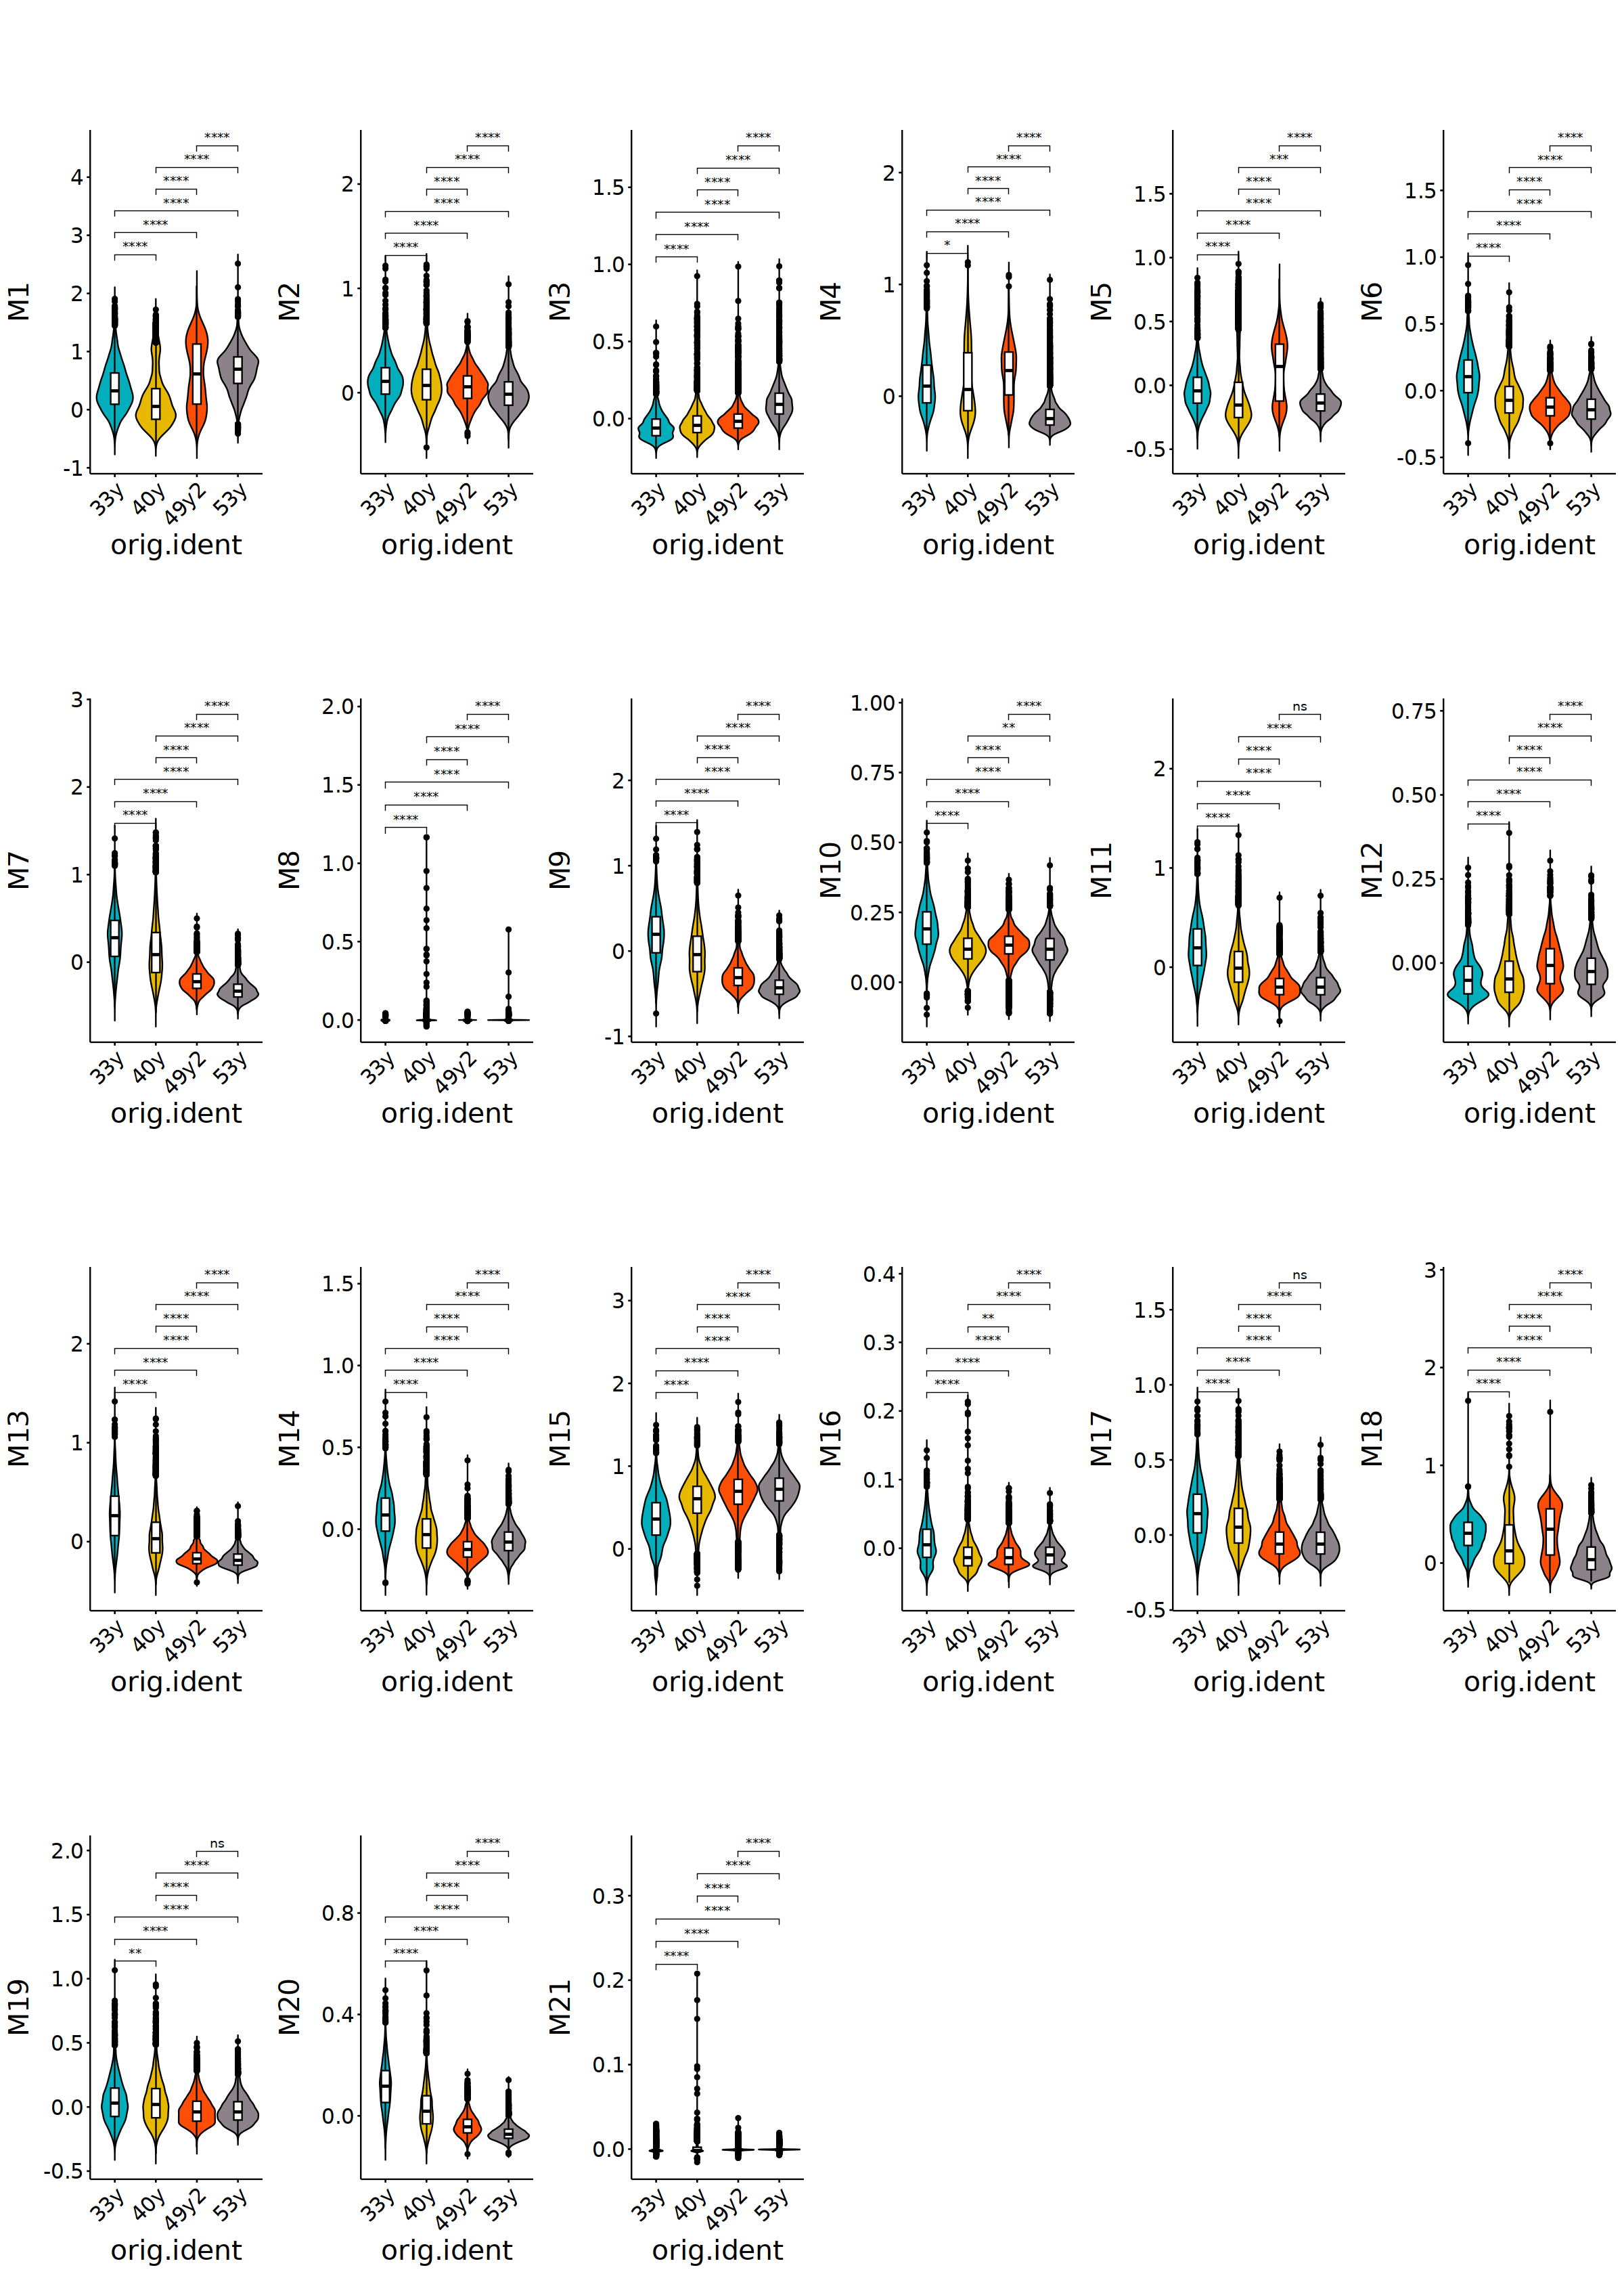

In [37]:
library(ggpubr)
pdflist={}
mytheme = theme(#plot.title = element_text(size = 20,color="black",hjust = 0.5),
                plot.title=element_blank(),
                 axis.title = element_text(size =24,color ="black"),
                 axis.text = element_text(size=18,color = "black"),
                 panel.grid.minor.y = element_blank(),
                 panel.grid.minor.x = element_blank(),
                  panel.grid=element_blank(), # 去网格线
                 legend.text = element_text(size=14),
                 legend.title= element_text(size= 18),
                 axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
                 plot.margin = unit(c(8,0.5,0.5,0.5),"lines"),
                 legend.position="none")
for(i in (1:length(names))){
    pdflist[[i]]=ggviolin(scRNA.score@meta.data, x = "orig.ident", y =names[i] ,fill = "orig.ident", add.params = list(fill = "white"),palette =c("#00AFBB", "#E7B800", "#FC4E07", "#8c838a"),add = "boxplot")+ylab(names2[i])+mytheme+ stat_compare_means(comparisons = my_comparisons,label = "p.signif")
}

p=CombinePlots(
  plots = pdflist,
  #nrow =6,
  ncol=6 
)
ggsave(paste0(prefix,".Modulescore.violin.stage.pdf"),plot=p,w=20,h=28)
options(repr.plot.width =20,repr.plot.height =28)
p

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


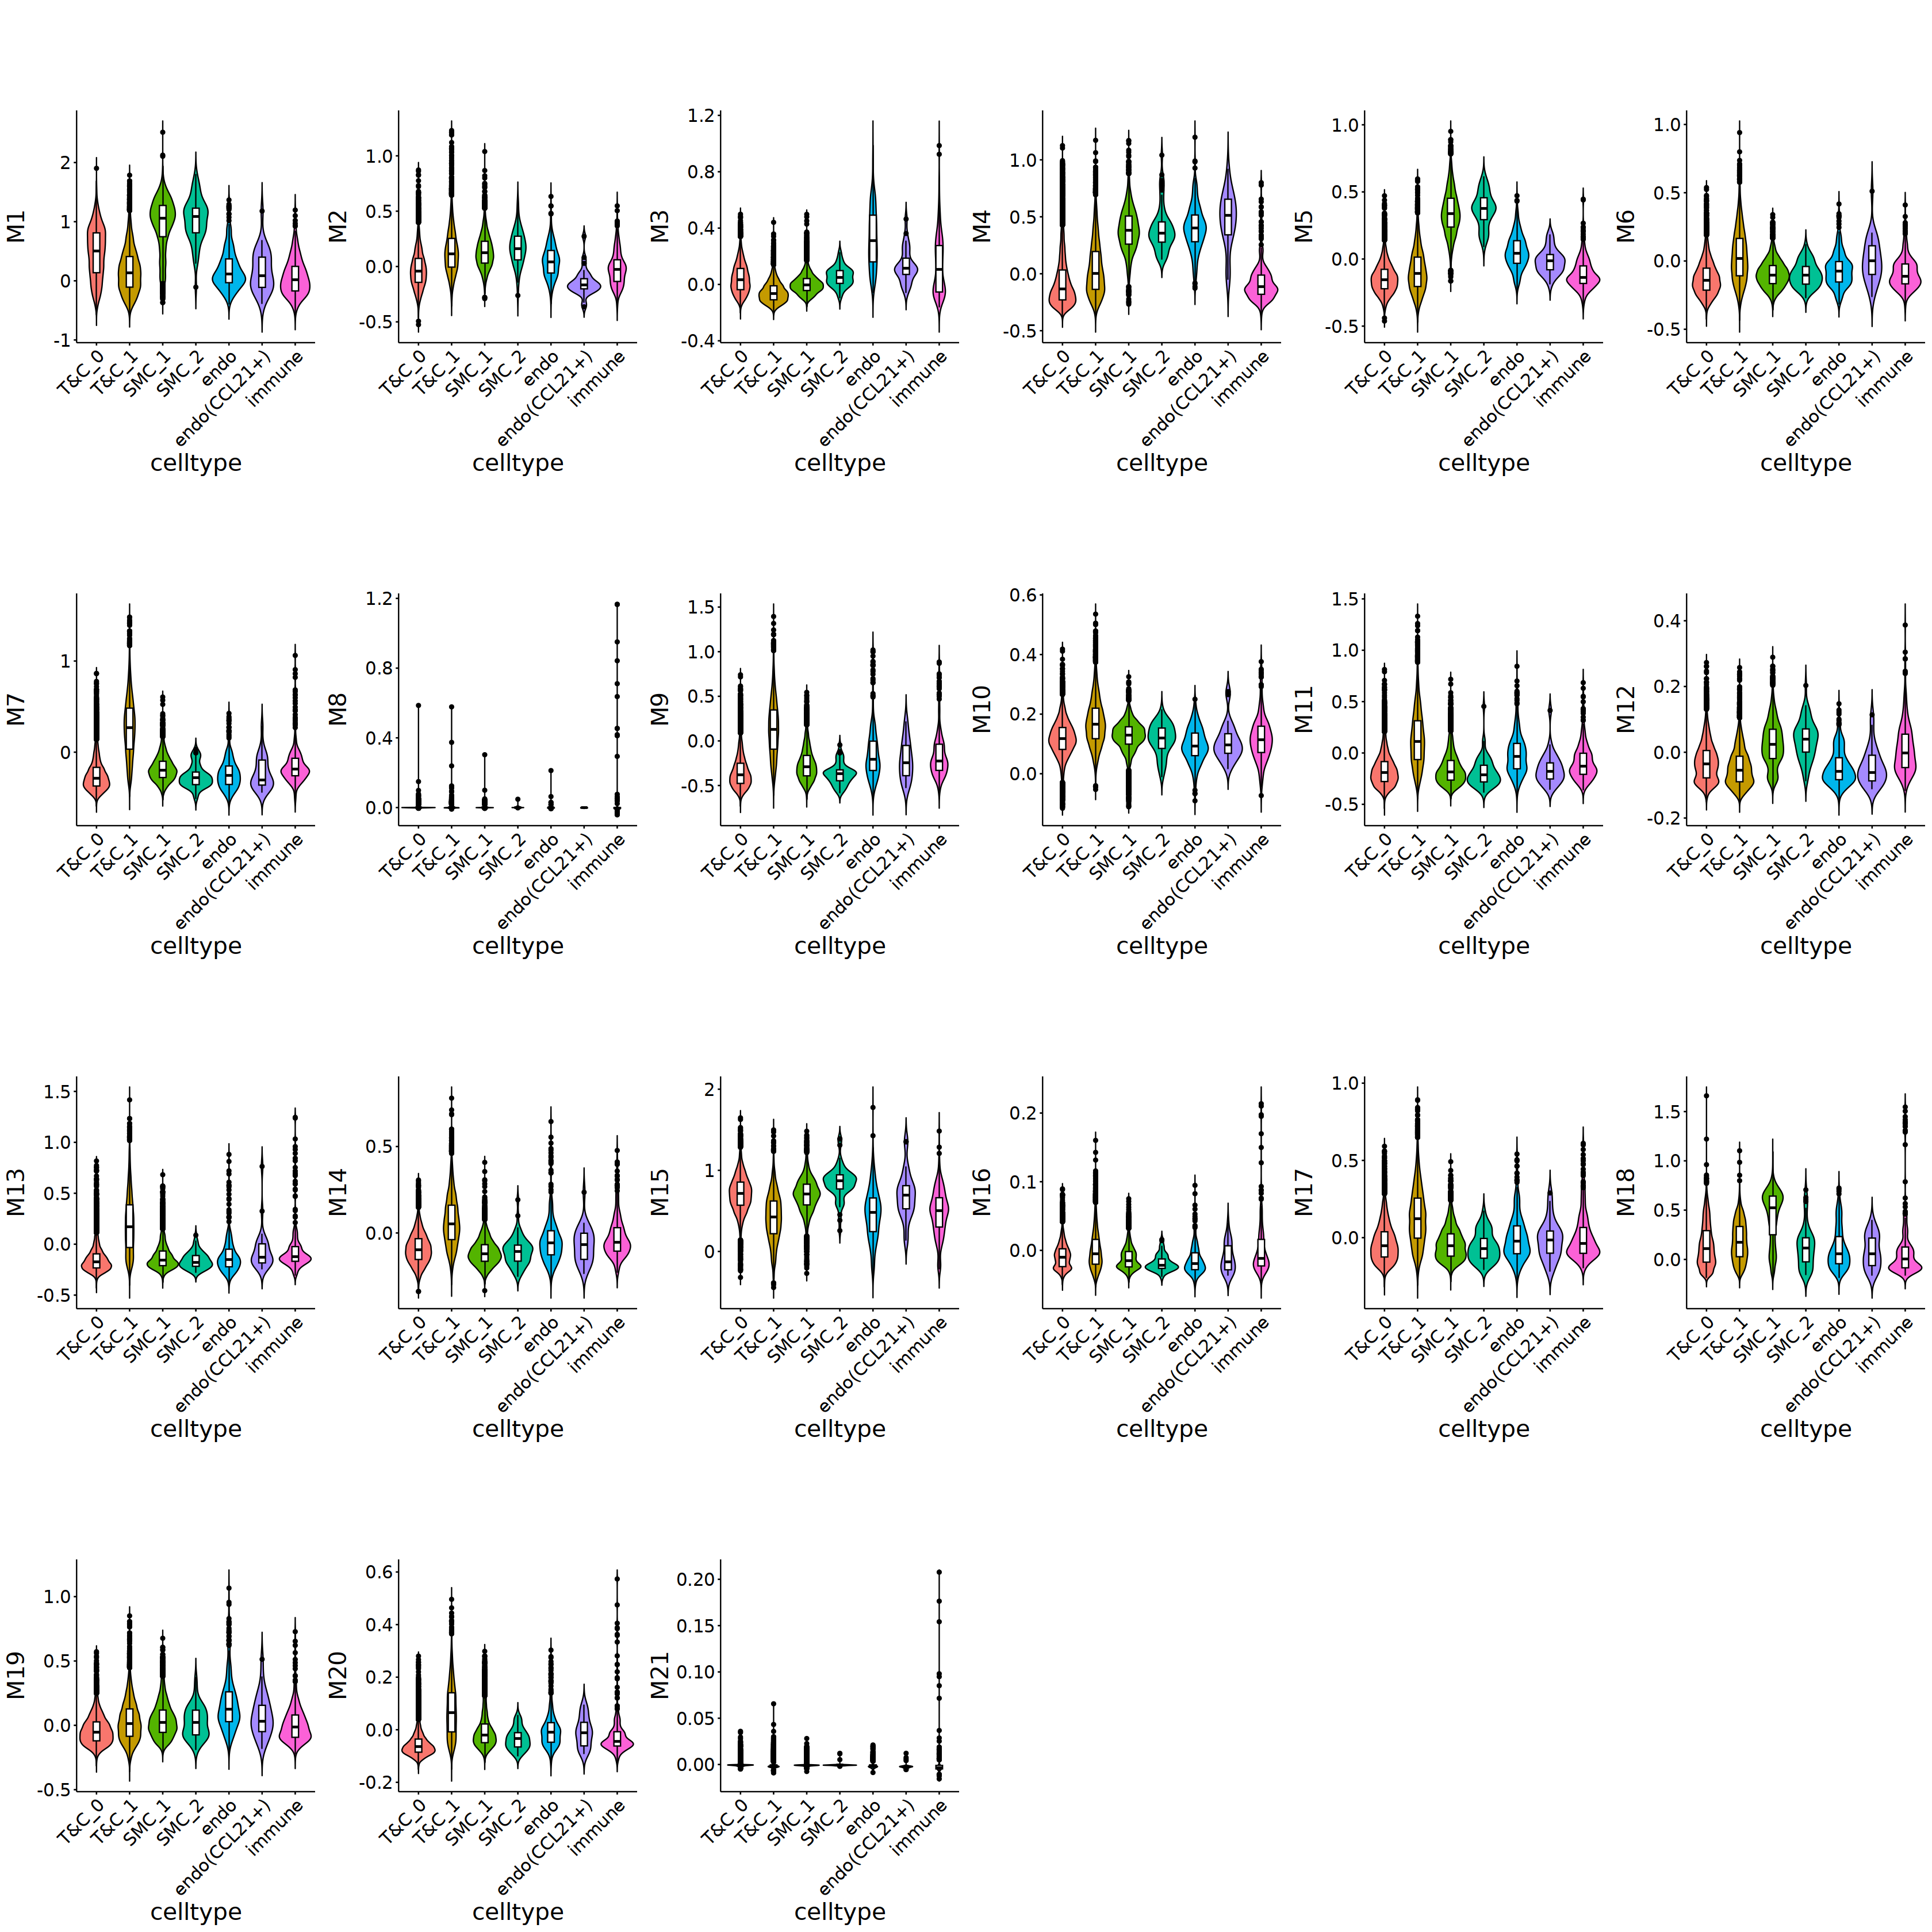

In [41]:
library(ggpubr)
pdflist={}
mytheme = theme(#plot.title = element_text(size = 20,color="black",hjust = 0.5),
                plot.title=element_blank(),
                 axis.title = element_text(size =24,color ="black"),
                 axis.text = element_text(size=18,color = "black"),
                 panel.grid.minor.y = element_blank(),
                 panel.grid.minor.x = element_blank(),
                  panel.grid=element_blank(), # 去网格线
                 legend.text = element_text(size=14),
                 legend.title= element_text(size= 18),
                 axis.text.x = element_text(angle = 45, hjust=1, vjust=1),
                 plot.margin = unit(c(8,0.5,0.5,0.5),"lines"),
                 legend.position="none")
for(i in (1:length(names))){
    pdflist[[i]]=ggviolin(scRNA.score@meta.data, x = "celltype", y =names[i] ,fill = "celltype", add.params = list(fill = "white"),add = "boxplot")+ylab(names2[i])+mytheme#+ stat_compare_means(comparisons = my_comparisons,label = "p.signif")
}

p=CombinePlots(
  plots = pdflist,
  #nrow =6,
  ncol=6 
)
ggsave(paste0(prefix,".Modulescore2.violin.stage.pdf"),plot=p,w=28,h=28)
options(repr.plot.width =28,repr.plot.height =28)
p